In [1]:
# --- Required Libraries ---
import numpy as np                            # For numerical computations
import pandas as pd                          # For handling datasets
import random                                 # For generating random numbers

# --- For Visualizations (Data analysis) ---
import matplotlib.pyplot as plt               # For creating basic plots and graphs
import seaborn as sns                        # For enhanced visualizations (e.g., heatmaps, pairplots)
from matplotlib.lines import Line2D           # For advanced plotting (e.g., legends with custom lines)

# --- For Statistical Description (Descriptive statistics and statistical analysis) ---
import scipy.stats as stats                  # For statistical functions like skew, kurtosis
from sklearn.preprocessing import MinMaxScaler # For scaling and normalization

# --- For Preprocessing (Data cleaning, encoding, balancing, etc.) ---
from sklearn.model_selection import train_test_split # For splitting datasets into train, validation, and test sets
from sklearn.preprocessing import LabelEncoder           # For encoding categorical variables into numeric labels
from sklearn.impute import SimpleImputer                # For handling missing values (mean/median imputation)
from sklearn.utils import resample                      # For up/down sampling the dataset

# --- For LSTM (Deep Learning) (Model building and training) ---
import tensorflow as tf                             # TensorFlow for building and training deep learning models
from tensorflow.keras.models import Sequential      # For creating sequential models
from tensorflow.keras.models import Model           # For using the functional API to build models
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional # For LSTM layers and others
from tensorflow.keras.optimizers import Adam        # Adam optimizer for model training
from tensorflow.keras.callbacks import EarlyStopping # Early stopping to prevent overfitting

# --- For Metrics (For evaluating model performance) ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # For regression evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix  # For classification metrics


2025-07-04 11:49:31.986879: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the dataset
data = pd.read_csv('/Users/administrator/Desktop/All desktop-data/Dr.Ali/dataset/Dataset and Code/Dataset/iot_smart_city_dataset.csv')

# Display descriptive statistics
print("Descriptive Statistics for the Dataset:\n", data.describe())


Descriptive Statistics for the Dataset:
        uptime_hours  battery_capacity_mAh  energy_consumption_mAh  \
count  60000.000000          60000.000000            60000.000000   
mean      11.571667           3004.149850              186.828537   
std        6.920831           1153.084715              111.739189   
min        0.000000           1000.000000                0.000000   
25%        6.000000           2007.000000               96.872063   
50%       12.000000           3010.000000              193.744126   
75%       18.000000           3998.250000              290.616188   
max       23.000000           4999.000000              371.342907   

       temperature_C  humidity_percent  air_quality_index  motion_events  \
count   60000.000000      60000.000000       60000.000000   60000.000000   
mean       24.992034         82.505883         248.967000      49.442550   
std         5.768543          5.948904         144.015029      28.843315   
min        15.000169         70.0

In [3]:
# Check the columns in the dataset
print(data.columns)


Index(['timestamp', 'device_id', 'device_type', 'uptime_hours',
       'battery_capacity_mAh', 'energy_consumption_mAh', 'temperature_C',
       'humidity_percent', 'air_quality_index', 'motion_events',
       'light_intensity_lux', 'noise_level_dB', 'co2_emissions_ppm',
       'wind_speed_m_s', 'precipitation_mm_h', 'traffic_density_vehicles_h',
       'noise_pollution_level_dB', 'anomaly'],
      dtype='object')


In [4]:
# Rename columns for easier access
rename_dict = {
    'timestamp': 'TS', 'device_id': 'DID', 'device_type': 'Type', 
    'uptime_hours': 'UPU', 'battery_capacity_mAh': 'BC', 
    'energy_consumption_mAh': 'EC', 'temperature_C': 'Temp', 
    'humidity_percent': 'Hum', 'air_quality_index': 'AQI', 
    'motion_events': 'ME', 'light_intensity_lux': 'Lux', 
    'noise_level_dB': 'NL', 'co2_emissions_ppm': 'CO2', 
    'wind_speed_m_s': 'WS', 'precipitation_mm_h': 'Precip', 
    'traffic_density_vehicles_h': 'TDV', 'noise_pollution_level_dB': 'NPL', 
    'anomaly': 'Anom'
}
data.rename(columns=rename_dict, inplace=True)

# Features (input variables) and targets (outputs)
features = ['UPU', 'BC', 'Temp', 'Hum', 'AQI', 'ME', 'Lux', 'NL', 'CO2', 'WS', 'Precip', 'TDV', 'NPL']
X = data[features]  # Input features
y_energy = data['EC']  # Energy consumption target (regression)
y_anomaly = data['Anom']  # Anomaly detection target (binary classification)

# Split the data into training and validation sets (80%/20%)
X_train, X_val, y_train_energy, y_val_energy, y_train_anomaly, y_val_anomaly = train_test_split(
    X, y_energy, y_anomaly, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}, Validation set shape: {X_val.shape}")


Training set shape: (48000, 13), Validation set shape: (12000, 13)


In [5]:
# --- Scaling the features ---
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Reshape the data for LSTM [samples, timesteps, features]
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))


In [6]:
# --- Build the LSTM Model for EC (Energy Consumption) ---
model = Sequential([
    LSTM(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.3),
    Dense(1, name='EC_output')  # Output layer for energy consumption (regression)
])

# --- Compile the model ---
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[r2_score])

# Print model summary to check layers
model.summary()


/Users/administrator/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ EC_output (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras import backend as K

# Define R² metric function
def r2_metric(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))  # Residual sum of squares
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))  # Total sum of squares
    return 1 - ss_res / (ss_tot + K.epsilon())  # R² formula


In [8]:
# --- Compile the model for Energy Consumption prediction ---
model.compile(
    optimizer='adam',
    loss='mean_squared_error',  # For regression
    metrics=[r2_metric]  # Use the custom R² metric
)


In [9]:
history = model.fit(
    X_train_reshaped, 
    y_train_energy,  # Energy Consumption output (EC)
    epochs=50, 
    batch_size=32, 
    validation_data=(X_val_reshaped, y_val_energy),
    verbose=1
)


Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 38650.2148 - r2_metric: -2.2623 - val_loss: 22382.0723 - val_r2_metric: -0.8973
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 20011.0039 - r2_metric: -0.6918 - val_loss: 14647.5283 - val_r2_metric: -0.2317
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 14114.8848 - r2_metric: -0.1696 - val_loss: 8944.1553 - val_r2_metric: 0.2486
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7074.8877 - r2_metric: 0.4121 - val_loss: 2855.3047 - val_r2_metric: 0.7617
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2670.0967 - r2_metric: 0.7778 - val_loss: 1133.3284 - val_r2_metric: 0.9059
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1318.7078 - r2_metric: 0.8913 - val_loss: 451.6507 - val_r2_metric: 0.9626
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 866.9604 - r2_metric: 0.9276 - val_loss: 207.6404 - val_r2_metric: 0.9828
Epoch 8/50
1500/1500 ━━━━━━

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 259.7036 - r2_metric: 0.9780 - val_loss: 7.1955 - val_r2_metric: 0.9994
Epoch 50/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 264.1920 - r2_metric: 0.9776 - val_loss: 4.7351 - val_r2_metric: 0.9996


In [10]:
# --- Evaluate the model on validation data ---
y_pred_energy = model.predict(X_val_reshaped)

# Compute the evaluation metrics
mae = mean_absolute_error(y_val_energy, y_pred_energy)
mse = mean_squared_error(y_val_energy, y_pred_energy)
rmse = np.sqrt(mse)

# For R², TensorFlow's internal R² is used in the training process
train_r2 = history.history['r2_metric'][-1]  # Get the final R² for training
val_r2 = history.history['val_r2_metric'][-1]  # Get the final R² for validation

# Print final metrics for energy consumption (EC)
print(f"Final EC Metrics:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"Training R²: {train_r2}")
print(f"Validation R²: {val_r2}")


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Final EC Metrics:
MAE: 1.6734326916249294
MSE: 4.73508756174542
RMSE: 2.1760256344412445
Training R²: 0.9781556129455566
Validation R²: 0.9996026754379272


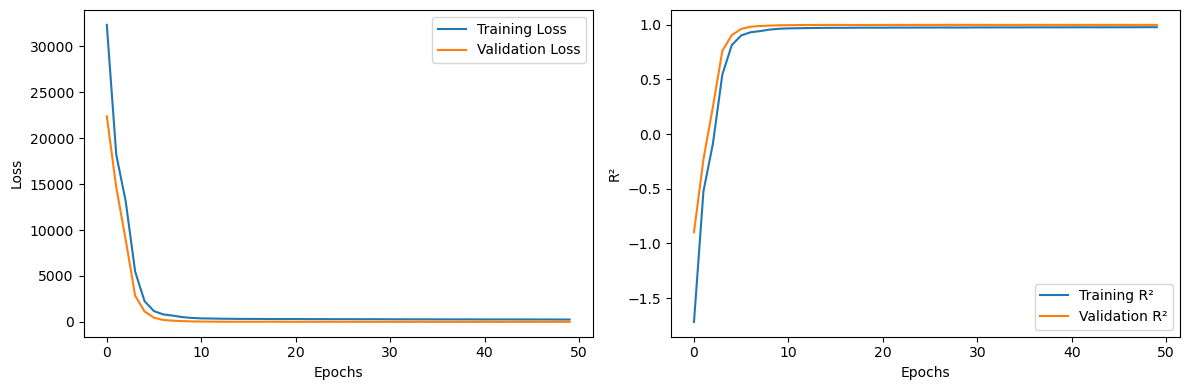

In [11]:
import matplotlib.pyplot as plt

# --- Create a figure with 1 row and 2 columns ---
plt.figure(figsize=(12, 4))

# --- First Plot: EC - Training and Validation Loss ---
plt.subplot(1, 2, 1)  # First subplot (1 row, 2 columns, first plot)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.title('EC - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# --- Second Plot: EC - R² Score Across Epochs ---
plt.subplot(1, 2, 2)  # Second subplot (1 row, 2 columns, second plot)
plt.plot(history.history['r2_metric'], label='Training R²')  # Training R²
plt.plot(history.history['val_r2_metric'], label='Validation R²')  # Validation R²
# plt.title('EC - R² Score Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.legend()

# --- Adjust layout for better spacing ---
plt.tight_layout()

# --- Show the plots ---
plt.show()


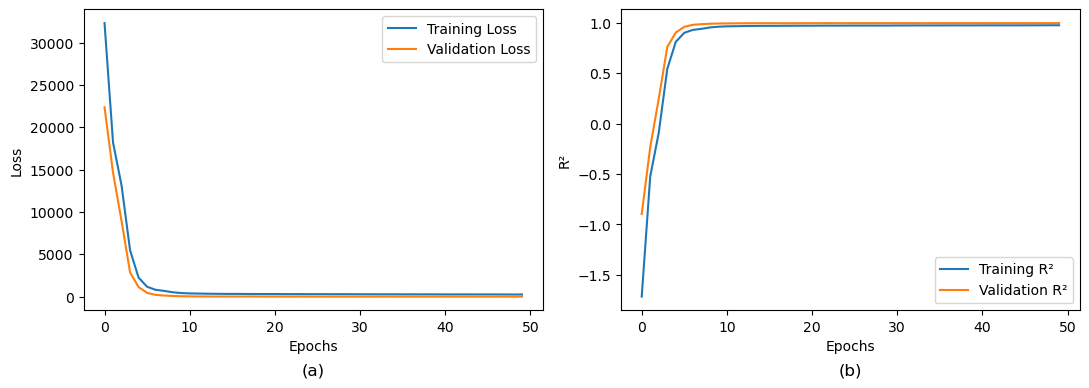

In [12]:
import matplotlib.pyplot as plt

# --- Create a figure with 1 row and 2 columns ---
plt.figure(figsize=(11, 4))

# --- First Plot: EC - Training and Validation Loss ---
plt.subplot(1, 2, 1)  # First subplot (1 row, 2 columns, first plot)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.title('EC - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.text(0.5, -0.20, '(a)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)

# --- Second Plot: EC - R² Score Across Epochs ---
plt.subplot(1, 2, 2)  # Second subplot (1 row, 2 columns, second plot)
plt.plot(history.history['r2_metric'], label='Training R²')  # Training R²
plt.plot(history.history['val_r2_metric'], label='Validation R²')  # Validation R²
# plt.title('EC - R² Score Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.legend()
plt.text(0.5, -0.20, '(b)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)

# --- Adjust layout for better spacing ---
plt.tight_layout()

# --- Show the plots ---
plt.show()


In [13]:
# Store the final evaluation results in history
history_dict = history.history

# Print the final training and validation loss and R² metrics
print(f"Training Loss: {history_dict['loss'][-1]}")
print(f"Validation Loss: {history_dict['val_loss'][-1]}")
print(f"Training R²: {history_dict['r2_metric'][-1]}")
print(f"Validation R²: {history_dict['val_r2_metric'][-1]}")


Training Loss: 259.1782531738281
Validation Loss: 4.735085487365723
Training R²: 0.9781556129455566
Validation R²: 0.9996026754379272


In [14]:
# Step 1: Add 30% Noise to the Data
def add_noise_to_data(data, noise_level=0.3):  # 30% noise
    noisy_data = data.copy()
    numeric_features = features  # Using the features list for numeric columns

    for feature in numeric_features:
        noise = np.random.normal(loc=0, scale=noise_level * noisy_data[feature].mean(), size=len(noisy_data))
        noisy_data[feature] += noise
    
    return noisy_data

# Add 30% noise to the training and validation sets (no need for test data in this case)
X_train_noisy_30 = add_noise_to_data(X_train, noise_level=0.3)  # 30% noise
X_val_noisy_30 = add_noise_to_data(X_val, noise_level=0.3)      # 30% noise

# Verify that noise is added to the data (optional: print the first few rows)
print("Noisy data samples (30% noise):")
print(X_train_noisy_30.head())



Noisy data samples (30% noise):
             UPU           BC       Temp        Hum         AQI         ME  \
48572   6.373855  3215.122165  30.978506  64.622123  253.030015 -10.532565   
38696  21.586487  3265.302793  24.886786  27.131642  424.965467  38.927145   
13611   5.907147  4294.818216  31.150377  82.435661  155.702565  50.607986   
35213   9.494012  4563.658611  25.978349  22.137672  223.167303  86.148571   
31766   6.867325  3235.113556  27.699537  63.612914  409.918749  56.681443   

               Lux         NL         CO2         WS     Precip         TDV  \
48572   894.335583  49.133226  581.509586   8.701631  18.621418  -18.389278   
38696   616.256590  36.404512  440.976929  13.055041   9.955683   58.531105   
13611  1103.067933  33.917985  124.206566  17.275482   4.369679   29.271140   
35213  1011.045283  33.753891  546.761031  12.421134  21.973231  105.361856   
31766   990.966727  44.606663  421.915635  15.046999  21.402826   67.026546   

              NPL  
4857

In [15]:
# Step 2: Scale the noisy data (using the same scaler)
scaler = MinMaxScaler()

# Fit and transform the scaler on the noisy training data
X_train_noisy_30_scaled = scaler.fit_transform(X_train_noisy_30)
X_val_noisy_30_scaled = scaler.transform(X_val_noisy_30)

# Reshape the data for LSTM [samples, timesteps, features]
X_train_noisy_30_reshaped = X_train_noisy_30_scaled.reshape((X_train_noisy_30_scaled.shape[0], 1, X_train_noisy_30_scaled.shape[1]))
X_val_noisy_30_reshaped = X_val_noisy_30_scaled.reshape((X_val_noisy_30_scaled.shape[0], 1, X_val_noisy_30_scaled.shape[1]))

# Optionally: Print the shape of reshaped data to verify
print(f"X_train_noisy_30_reshaped shape: {X_train_noisy_30_reshaped.shape}")
print(f"X_val_noisy_30_reshaped shape: {X_val_noisy_30_reshaped.shape}")


X_train_noisy_30_reshaped shape: (48000, 1, 13)
X_val_noisy_30_reshaped shape: (12000, 1, 13)


In [16]:
# Step 3: Build the LSTM Model for 30% Noisy Data
model = Sequential([
    LSTM(64, input_shape=(X_train_noisy_30_reshaped.shape[1], X_train_noisy_30_reshaped.shape[2])),
    Dropout(0.3),
    Dense(1, name='EC_output')  # Output layer for energy consumption (regression)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[r2_metric])

# Print model summary
model.summary()


/Users/administrator/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ EC_output (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Step 4: Train the model on 30% noisy data
history_30 = model.fit(
    X_train_noisy_30_reshaped,  # 30% noisy data
    y_train_energy,  # Energy Consumption output (EC)
    epochs=50, 
    batch_size=32, 
    validation_data=(X_val_noisy_30_reshaped, y_val_energy),  # 30% noisy validation data
    verbose=1
)


Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 38782.3750 - r2_metric: -2.2579 - val_loss: 22550.4512 - val_r2_metric: -0.9117
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 20472.7266 - r2_metric: -0.7177 - val_loss: 14730.1963 - val_r2_metric: -0.2388
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 14324.2695 - r2_metric: -0.1782 - val_loss: 12591.8018 - val_r2_metric: -0.0543
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 12858.9268 - r2_metric: -0.0657 - val_loss: 10249.0420 - val_r2_metric: 0.1411
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 8779.0830 - r2_metric: 0.2670 - val_loss: 4821.4580 - val_r2_metric: 0.5945
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4573.2729 - r2_metric: 0.6202 - val_loss: 3186.6716 - val_r2_metric: 0.7300
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3436.8276 - r2_metric: 0.7075 - val_loss: 2746.9031 - val_r2_metric: 0.7658
Epoch 8/50
1500/150

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2593.2490 - r2_metric: 0.7813 - val_loss: 2322.1536 - val_r2_metric: 0.8006
Epoch 49/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2607.0537 - r2_metric: 0.7781 - val_loss: 2322.7605 - val_r2_metric: 0.8004
Epoch 50/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2636.1160 - r2_metric: 0.7753 - val_loss: 2314.1301 - val_r2_metric: 0.8011


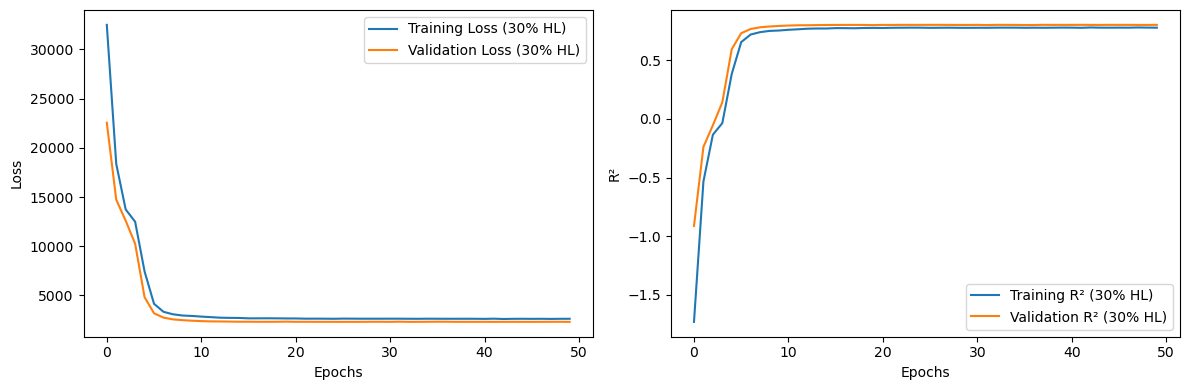

In [18]:
# Step 7: Plot the training and validation loss and R² metrics
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
plt.figure(figsize=(12, 4))

# First Plot: EC - Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history_30.history['loss'], label='Training Loss (30% HL)')
plt.plot(history_30.history['val_loss'], label='Validation Loss (30% HL)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Second Plot: EC - R² Score Across Epochs
plt.subplot(1, 2, 2)
plt.plot(history_30.history['r2_metric'], label='Training R² (30% HL)')
plt.plot(history_30.history['val_r2_metric'], label='Validation R² (30% HL)')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

In [19]:
# Step 5: Evaluate the model on validation data
y_pred_energy_30 = model.predict(X_val_noisy_30_reshaped)

# Compute the evaluation metrics
mae_30 = mean_absolute_error(y_val_energy, y_pred_energy_30)  # MAE on validation data
mse_30 = mean_squared_error(y_val_energy, y_pred_energy_30)   # MSE on validation data
rmse_30 = np.sqrt(mse_30)                                     # RMSE on validation data

# For R², TensorFlow's internal R² is used in the training process
train_r2_30 = history_30.history['r2_metric'][-1]  # Final R² for training on 30% noisy data
val_r2_30 = history_30.history['val_r2_metric'][-1]  # Final R² for validation on 30% noisy data

# Step 6: Print final metrics for energy consumption (EC) on 30% noisy data
print(f"Final EC Metrics for 30% Noisy Data:")
print(f"MAE: {mae_30}")
print(f"MSE: {mse_30}")
print(f"RMSE: {rmse_30}")
print(f"Training R²: {train_r2_30}")
print(f"Validation R²: {val_r2_30}")


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
Final EC Metrics for 30% Noisy Data:
MAE: 38.029369814450476
MSE: 2314.13004998762
RMSE: 48.10540562127733
Training R²: 0.7769811153411865
Validation R²: 0.8011009097099304


In [20]:
# Step 1: Add 50% Noise to the Data
def add_noise_to_data(data, noise_level=0.5):  # 50% noise
    noisy_data = data.copy()
    numeric_features = features  # Using the features list for numeric columns

    for feature in numeric_features:
        noise = np.random.normal(loc=0, scale=noise_level * noisy_data[feature].mean(), size=len(noisy_data))
        noisy_data[feature] += noise
    
    return noisy_data

# Add 50% noise to the training and validation sets (no need for test data)
X_train_noisy_50 = add_noise_to_data(X_train, noise_level=0.5)  # 50% noise
X_val_noisy_50 = add_noise_to_data(X_val, noise_level=0.5)      # 50% noise

# Verify that noise is added to the data (optional: print the first few rows)
print("Noisy data samples (50% noise):")
print(X_train_noisy_50.head())



Noisy data samples (50% noise):
             UPU           BC       Temp         Hum         AQI         ME  \
48572  -1.274337  5859.357789  25.562597   85.364120  212.077454 -44.572036   
38696  25.848615   125.765276  22.756518   79.281662  630.359450  36.906801   
13611   7.657737  4649.018017  49.016919   81.238263  134.005004  54.629526   
35213   4.297317  6219.515521  40.505896   98.829126   10.189657  65.866863   
31766  -1.640805  2331.776684  20.554768  152.534983  588.480041  45.291425   

               Lux         NL         CO2         WS     Precip         TDV  \
48572  1320.603563  86.430982  333.703476  -8.768249  14.682171  -18.969774   
38696  1116.349500  28.993699  471.916134  16.021048  19.218781   -1.928741   
13611  1712.059138  10.518994  151.340930  21.191235   2.722928   71.348424   
35213  1117.244810  25.356612   62.995903   9.032540  28.650512  103.864908   
31766  1162.835731  42.845316  566.617647  11.912973  17.650233   78.739176   

              NPL 

In [21]:
# Step 2: Scale the noisy data (using the same scaler)
scaler = MinMaxScaler()

# Fit and transform the scaler on the noisy training data
X_train_noisy_50_scaled = scaler.fit_transform(X_train_noisy_50)
X_val_noisy_50_scaled = scaler.transform(X_val_noisy_50)

# Reshape the data for LSTM [samples, timesteps, features]
X_train_noisy_50_reshaped = X_train_noisy_50_scaled.reshape((X_train_noisy_50_scaled.shape[0], 1, X_train_noisy_50_scaled.shape[1]))
X_val_noisy_50_reshaped = X_val_noisy_50_scaled.reshape((X_val_noisy_50_scaled.shape[0], 1, X_val_noisy_50_scaled.shape[1]))

# Optionally: Print the shape of reshaped data to verify
print(f"X_train_noisy_50_reshaped shape: {X_train_noisy_50_reshaped.shape}")
print(f"X_val_noisy_50_reshaped shape: {X_val_noisy_50_reshaped.shape}")


X_train_noisy_50_reshaped shape: (48000, 1, 13)
X_val_noisy_50_reshaped shape: (12000, 1, 13)


In [22]:
# Step 3: Build the LSTM Model for 50% Noisy Data
model = Sequential([
    LSTM(64, input_shape=(X_train_noisy_50_reshaped.shape[1], X_train_noisy_50_reshaped.shape[2])),
    Dropout(0.3),
    Dense(1, name='EC_output')  # Output layer for energy consumption (regression)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[r2_metric])

# Print model summary
model.summary()


/Users/administrator/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ EC_output (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Step 4: Train the model on 50% noisy data
history_50 = model.fit(
    X_train_noisy_50_reshaped,  # 50% noisy data
    y_train_energy,  # Energy Consumption output (EC)
    epochs=50, 
    batch_size=32, 
    validation_data=(X_val_noisy_50_reshaped, y_val_energy),  # 50% noisy validation data
    verbose=1
)


Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 38736.1055 - r2_metric: -2.2754 - val_loss: 22327.9902 - val_r2_metric: -0.8926
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 19996.8691 - r2_metric: -0.6757 - val_loss: 14621.4902 - val_r2_metric: -0.2294
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 14111.7803 - r2_metric: -0.1724 - val_loss: 12576.2031 - val_r2_metric: -0.0529
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 12922.9863 - r2_metric: -0.0637 - val_loss: 12362.0322 - val_r2_metric: -0.0343
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 11791.1338 - r2_metric: 0.0215 - val_loss: 8227.8838 - val_r2_metric: 0.3106
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7825.7979 - r2_metric: 0.3478 - val_loss: 6118.5049 - val_r2_metric: 0.4851
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6261.5117 - r2_metric: 0.4789 - val_loss: 5517.7056 - val_r2_metric: 0.5343
Epoch 8/50
1500/1

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5264.4702 - r2_metric: 0.5547 - val_loss: 4952.7852 - val_r2_metric: 0.5802
Epoch 49/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5288.8853 - r2_metric: 0.5546 - val_loss: 4948.6514 - val_r2_metric: 0.5805
Epoch 50/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5273.1392 - r2_metric: 0.5562 - val_loss: 4956.7817 - val_r2_metric: 0.5798


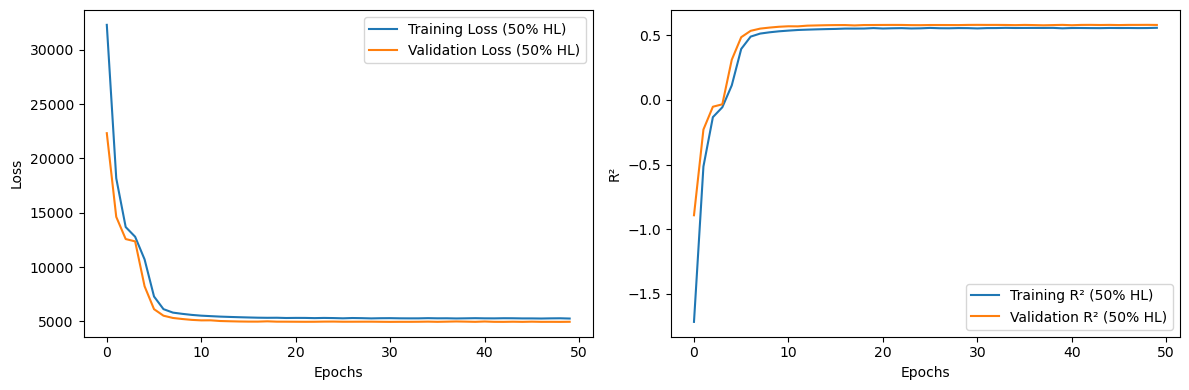

In [24]:
# Step 6: Plot the training and validation loss and R² metrics
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
plt.figure(figsize=(12, 4))

# First Plot: EC - Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history_50.history['loss'], label='Training Loss (50% HL)')
plt.plot(history_50.history['val_loss'], label='Validation Loss (50% HL)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Second Plot: EC - R² Score Across Epochs
plt.subplot(1, 2, 2)
plt.plot(history_50.history['r2_metric'], label='Training R² (50% HL)')
plt.plot(history_50.history['val_r2_metric'], label='Validation R² (50% HL)')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


In [25]:
# Step 5: Evaluate the model on validation data
y_pred_energy_50 = model.predict(X_val_noisy_50_reshaped)

# Compute the evaluation metrics
mae_50 = mean_absolute_error(y_val_energy, y_pred_energy_50)  # MAE on validation data
mse_50 = mean_squared_error(y_val_energy, y_pred_energy_50)   # MSE on validation data
rmse_50 = np.sqrt(mse_50)                                     # RMSE on validation data

# For R², TensorFlow's internal R² is used in the training process
train_r2_50 = history_50.history['r2_metric'][-1]  # Final R² for training on 50% noisy data
val_r2_50 = history_50.history['val_r2_metric'][-1]  # Final R² for validation on 50% noisy data

# Step 6: Print final metrics for energy consumption (EC) on 50% noisy data
print(f"Final EC Metrics for 50% Noisy Data:")
print(f"MAE: {mae_50}")
print(f"MSE: {mse_50}")
print(f"RMSE: {rmse_50}")
print(f"Training R²: {train_r2_50}")
print(f"Validation R²: {val_r2_50}")


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Final EC Metrics for 50% Noisy Data:
MAE: 56.388359093851584
MSE: 4956.780924063326
RMSE: 70.40440983392536
Training R²: 0.5577211380004883
Validation R²: 0.5798166394233704


In [26]:
# Step 1: Add 100% Noise to the Data
def add_noise_to_data(data, noise_level=1.0):  # 100% noise
    noisy_data = data.copy()
    numeric_features = features  # Using the features list for numeric columns

    for feature in numeric_features:
        noise = np.random.normal(loc=0, scale=noise_level * noisy_data[feature].mean(), size=len(noisy_data))
        noisy_data[feature] += noise
    
    return noisy_data

# Add 100% noise to the training and validation sets (no need for test data)
X_train_noisy_100 = add_noise_to_data(X_train, noise_level=1.0)  # 100% noise
X_val_noisy_100 = add_noise_to_data(X_val, noise_level=1.0)      # 100% noise

# Verify that noise is added to the data (optional: print the first few rows)
print("Noisy data samples (100% noise):")
print(X_train_noisy_100.head())


Noisy data samples (100% noise):
             UPU           BC       Temp         Hum         AQI          ME  \
48572  26.799924  5728.698271  68.578776  -35.517135  206.640881  -19.291361   
38696  -4.407964  2263.073582  24.313716   52.708184  122.411157   10.337047   
13611  -2.084415  3640.056364  13.690252 -138.547492  -76.132373   33.318751   
35213   4.332161  7922.629075  16.461211  157.812577  366.163006   84.226269   
31766  -3.061727 -1396.562478  31.972946  117.381480  269.462298  132.925186   

               Lux          NL         CO2         WS     Precip         TDV  \
48572   737.176638   49.963789  521.132156  -0.044279  11.969563  -80.687638   
38696   258.734750  119.892415    9.043283  17.482049  10.808205   36.872747   
13611   545.517831  -20.840084  659.483337  26.614330   2.380089   28.929292   
35213   499.695697  -33.630889  787.671579  16.300252  26.567523   65.138270   
31766  1326.646453    1.762550   72.989766  13.327801  15.037431  125.761354   

     

In [27]:
# Step 2: Scale the noisy data (using the same scaler)
scaler = MinMaxScaler()

# Fit and transform the scaler on the noisy training data
X_train_noisy_100_scaled = scaler.fit_transform(X_train_noisy_100)
X_val_noisy_100_scaled = scaler.transform(X_val_noisy_100)

# Reshape the data for LSTM [samples, timesteps, features]
X_train_noisy_100_reshaped = X_train_noisy_100_scaled.reshape((X_train_noisy_100_scaled.shape[0], 1, X_train_noisy_100_scaled.shape[1]))
X_val_noisy_100_reshaped = X_val_noisy_100_scaled.reshape((X_val_noisy_100_scaled.shape[0], 1, X_val_noisy_100_scaled.shape[1]))

# Optionally: Print the shape of reshaped data to verify
print(f"X_train_noisy_100_reshaped shape: {X_train_noisy_100_reshaped.shape}")
print(f"X_val_noisy_100_reshaped shape: {X_val_noisy_100_reshaped.shape}")


X_train_noisy_100_reshaped shape: (48000, 1, 13)
X_val_noisy_100_reshaped shape: (12000, 1, 13)


In [28]:
# Step 3: Build the LSTM Model for 100% Noisy Data
model = Sequential([
    LSTM(64, input_shape=(X_train_noisy_100_reshaped.shape[1], X_train_noisy_100_reshaped.shape[2])),
    Dropout(0.3),
    Dense(1, name='EC_output')  # Output layer for energy consumption (regression)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[r2_metric])

# Print model summary
model.summary()


/Users/administrator/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ EC_output (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Step 4: Train the model on 100% noisy data
history_100 = model.fit(
    X_train_noisy_100_reshaped,  # 100% noisy data
    y_train_energy,  # Energy Consumption output (EC)
    epochs=50, 
    batch_size=32, 
    validation_data=(X_val_noisy_100_reshaped, y_val_energy),  # 100% noisy validation data
    verbose=1
)


Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 38916.2344 - r2_metric: -2.2726 - val_loss: 22309.5020 - val_r2_metric: -0.8910
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 20237.7500 - r2_metric: -0.6889 - val_loss: 14612.9053 - val_r2_metric: -0.2287
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 14249.5410 - r2_metric: -0.1809 - val_loss: 12580.4150 - val_r2_metric: -0.0533
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 12864.0244 - r2_metric: -0.0662 - val_loss: 12371.6523 - val_r2_metric: -0.0351
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 12688.5830 - r2_metric: -0.0533 - val_loss: 12089.4150 - val_r2_metric: -0.0120
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 12029.1982 - r2_metric: 0.0025 - val_loss: 10565.2646 - val_r2_metric: 0.1145
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 10690.9141 - r2_metric: 0.1208 - val_loss: 9642.6963 - val_r2_metric: 0.1900
Epoch 8/50


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 9506.7041 - r2_metric: 0.2074 - val_loss: 8988.4707 - val_r2_metric: 0.2417
Epoch 49/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9564.9434 - r2_metric: 0.2053 - val_loss: 8988.0938 - val_r2_metric: 0.2417
Epoch 50/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9520.3857 - r2_metric: 0.2054 - val_loss: 9018.3789 - val_r2_metric: 0.2388


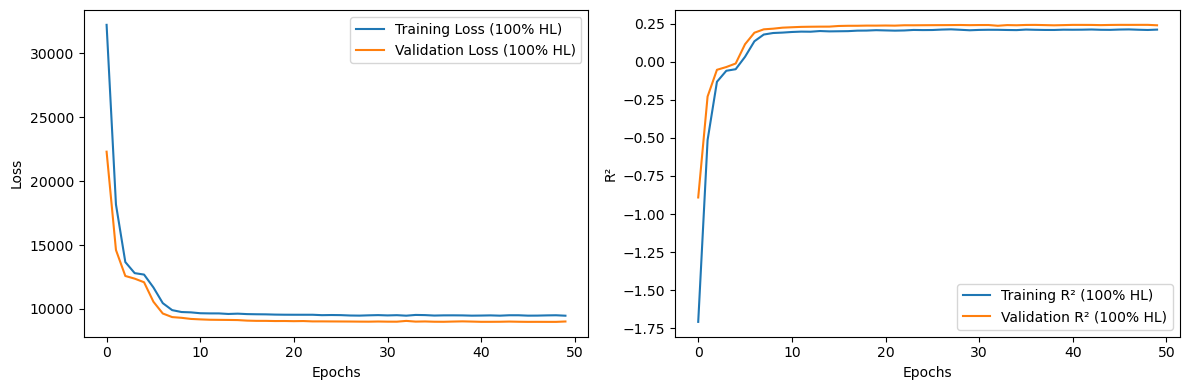

In [30]:
# Step 6: Plot the training and validation loss and R² metrics
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
plt.figure(figsize=(12, 4))

# First Plot: EC - Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history_100.history['loss'], label='Training Loss (100% HL)')
plt.plot(history_100.history['val_loss'], label='Validation Loss (100% HL)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Second Plot: EC - R² Score Across Epochs
plt.subplot(1, 2, 2)
plt.plot(history_100.history['r2_metric'], label='Training R² (100% HL)')
plt.plot(history_100.history['val_r2_metric'], label='Validation R² (100% HL)')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


In [31]:
# Step 5: Evaluate the model on validation data
y_pred_energy_100 = model.predict(X_val_noisy_100_reshaped)

# Compute the evaluation metrics
mae_100 = mean_absolute_error(y_val_energy, y_pred_energy_100)  # MAE on validation data
mse_100 = mean_squared_error(y_val_energy, y_pred_energy_100)   # MSE on validation data
rmse_100 = np.sqrt(mse_100)                                     # RMSE on validation data

# For R², TensorFlow's internal R² is used in the training process
train_r2_100 = history_100.history['r2_metric'][-1]  # Final R² for training on 100% noisy data
val_r2_100 = history_100.history['val_r2_metric'][-1]  # Final R² for validation on 100% noisy data

# Step 6: Print final metrics for energy consumption (EC) on 100% noisy data
print(f"Final EC Metrics for 100% Noisy Data:")
print(f"MAE: {mae_100}")
print(f"MSE: {mse_100}")
print(f"RMSE: {rmse_100}")
print(f"Training R²: {train_r2_100}")
print(f"Validation R²: {val_r2_100}")


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
Final EC Metrics for 100% Noisy Data:
MAE: 78.9825841515742
MSE: 9018.379599035898
RMSE: 94.96514939195272
Training R²: 0.2104114592075348
Validation R²: 0.23883238434791565


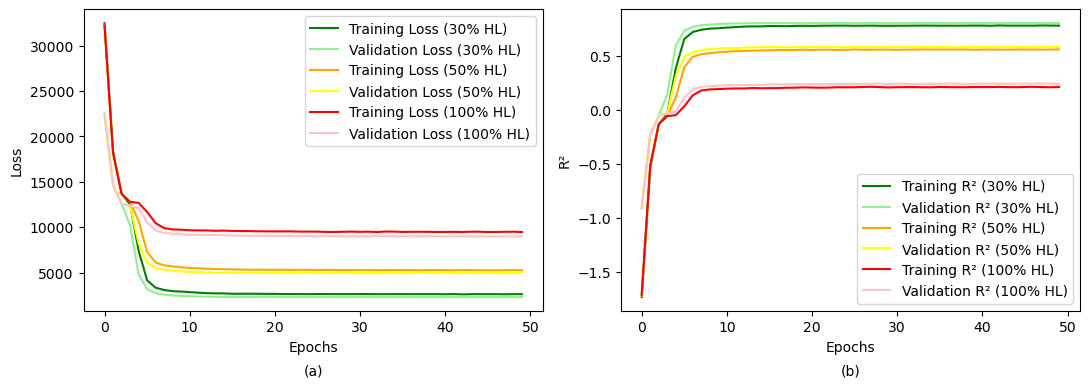

In [44]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
plt.figure(figsize=(11, 4))

# First Plot: Combined Loss (Training and Validation Loss for Original, 30%, 50%, and 100% HL)
plt.subplot(1, 2, 1)  # First subplot (1 row, 2 columns, first plot)
# Plot the training and validation loss for Original, 30%, 50%, and 100% HL
#plt.plot(history.history['loss'], label='Training Loss (Original)', color='blue')
#plt.plot(history.history['val_loss'], label='Validation Loss (Original)', color='cyan')

plt.plot(history_30.history['loss'], label='Training Loss (30% HL)', color='green')
plt.plot(history_30.history['val_loss'], label='Validation Loss (30% HL)', color='lightgreen')

plt.plot(history_50.history['loss'], label='Training Loss (50% HL)', color='orange')
plt.plot(history_50.history['val_loss'], label='Validation Loss (50% HL)', color='yellow')

plt.plot(history_100.history['loss'], label='Training Loss (100% HL)', color='red')
plt.plot(history_100.history['val_loss'], label='Validation Loss (100% HL)', color='pink')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.title('Training and Validation Loss')

# Add (a) label below x-axis for the first plot
plt.text(0.5, -0.20, '(a)', ha='center', va='center', transform=plt.gca().transAxes)

# Second Plot: Combined R² Scores (Training and Validation R² for Original, 30%, 50%, and 100% HL)
plt.subplot(1, 2, 2)  # Second subplot (1 row, 2 columns, second plot)
# Plot the training and validation R² for Original, 30%, 50%, and 100% HL
#plt.plot(history.history['r2_metric'], label='Training R² (Original)', color='blue')
#plt.plot(history.history['val_r2_metric'], label='Validation R² (Original)', color='cyan')

plt.plot(history_30.history['r2_metric'], label='Training R² (30% HL)', color='green')
plt.plot(history_30.history['val_r2_metric'], label='Validation R² (30% HL)', color='lightgreen')

plt.plot(history_50.history['r2_metric'], label='Training R² (50% HL)', color='orange')
plt.plot(history_50.history['val_r2_metric'], label='Validation R² (50% HL)', color='yellow')

plt.plot(history_100.history['r2_metric'], label='Training R² (100% HL)', color='red')
plt.plot(history_100.history['val_r2_metric'], label='Validation R² (100% HL)', color='pink')

plt.xlabel('Epochs')
plt.ylabel('R²')
plt.legend()
#plt.title('Training and Validation R²')

# Add (b) label below x-axis for the second plot
plt.text(0.5, -0.20, '(b)', ha='center', va='center', transform=plt.gca().transAxes)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


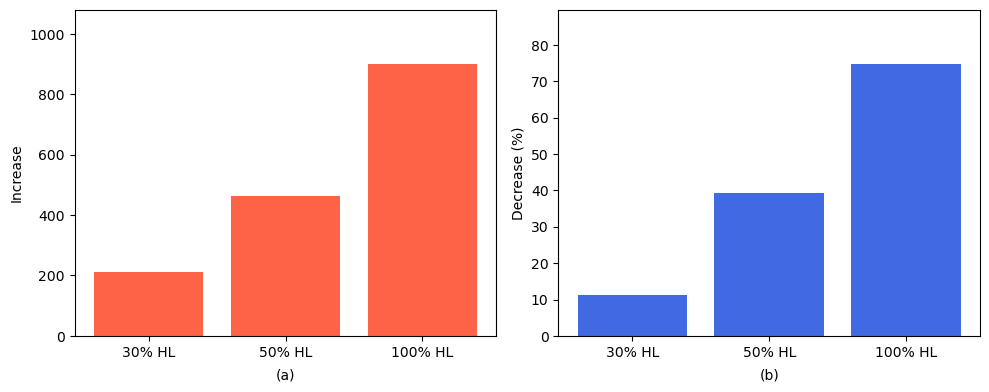

In [43]:
import matplotlib.pyplot as plt

# Final validation loss values (example values based on your plot)
validation_loss = {
    'Original': 800,
    '30% HL': 2500,
    '50% HL': 4500,
    '100% HL': 8000
}

# Final validation R² values (example values based on your plot)
validation_r2 = {
    'Original': 0.99,
    '30% HL': 0.88,
    '50% HL': 0.60,
    '100% HL': 0.25
}

# Calculate percentage increase in validation loss
baseline_loss = validation_loss['Original']
loss_percent_increase = {
    k: ((v - baseline_loss) / baseline_loss) * 100
    for k, v in validation_loss.items() if k != 'Original'
}

# Calculate percentage decrease in validation R²
baseline_r2 = validation_r2['Original']
r2_percent_decrease = {
    k: ((baseline_r2 - v) / baseline_r2) * 100
    for k, v in validation_r2.items() if k != 'Original'
}

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Loss percentage increase plot
ax[0].bar(loss_percent_increase.keys(), loss_percent_increase.values(), color='tomato')
# ax[0].set_title('Validation Loss: % Increase vs. Original')
ax[0].set_ylabel('Increase')
ax[0].set_ylim(0, max(loss_percent_increase.values()) * 1.2)

# Add (a) label below the x-axis for the first plot
ax[0].text(0.5, -0.12, '(a)', ha='center', va='center', transform=ax[0].transAxes)

# R² percentage decrease plot
ax[1].bar(r2_percent_decrease.keys(), r2_percent_decrease.values(), color='royalblue')
# ax[1].set_title('Validation R²: % Decrease vs. Original')
ax[1].set_ylabel('Decrease (%)')
ax[1].set_ylim(0, max(r2_percent_decrease.values()) * 1.2)

# Add (b) label below the x-axis for the second plot
ax[1].text(0.5, -0.12, '(b)', ha='center', va='center', transform=ax[1].transAxes)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


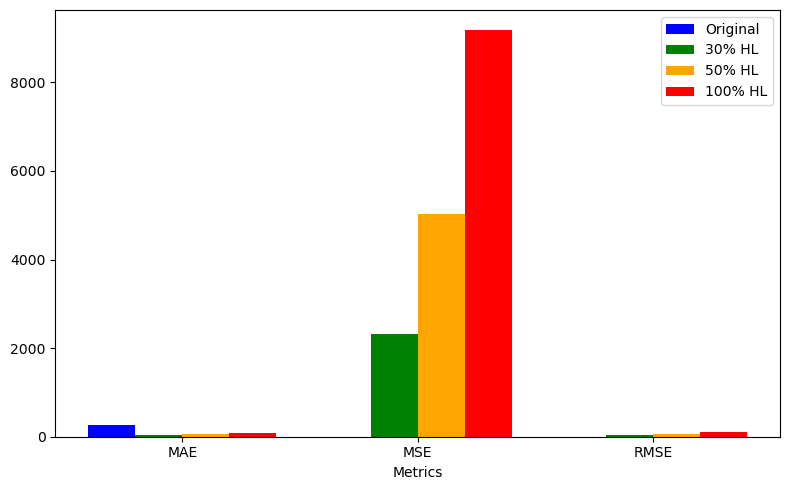

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for the Original, 30% HL, 50% HL, and 100% HL models (excluding R²)
labels = ['MAE', 'MSE', 'RMSE']

# Original data metrics
original_metrics = [256.0382385253906, np.nan, np.nan]  # No MSE or RMSE for Original data

# 30% HL data metrics
hl30_metrics = [38.03628049478659, 2326.0838274746366, 48.229491262863604]

# 50% HL data metrics
hl50_metrics = [56.55889720533405, 5020.73808622701, 70.85716679508863]

# 100% HL data metrics
hl100_metrics = [79.91422905910198, 9175.481129101627, 95.78873174388325]

# Create the bar plot
fig, ax = plt.subplots(figsize=(8, 5))

# Positioning of the bars
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

# Creating the bars for each set of metrics
rects1 = ax.bar(x - 1.5*width, original_metrics, width, label='Original', color='blue')
rects2 = ax.bar(x - 0.5*width, hl30_metrics, width, label='30% HL', color='green')
rects3 = ax.bar(x + 0.5*width, hl50_metrics, width, label='50% HL', color='orange')
rects4 = ax.bar(x + 1.5*width, hl100_metrics, width, label='100% HL', color='red')

# Add text labels, title, and custom x-axis tick labels
ax.set_xlabel('Metrics')
#ax.set_title('Comparison of Model Metrics for Different HL Levels (Excluding R²)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step


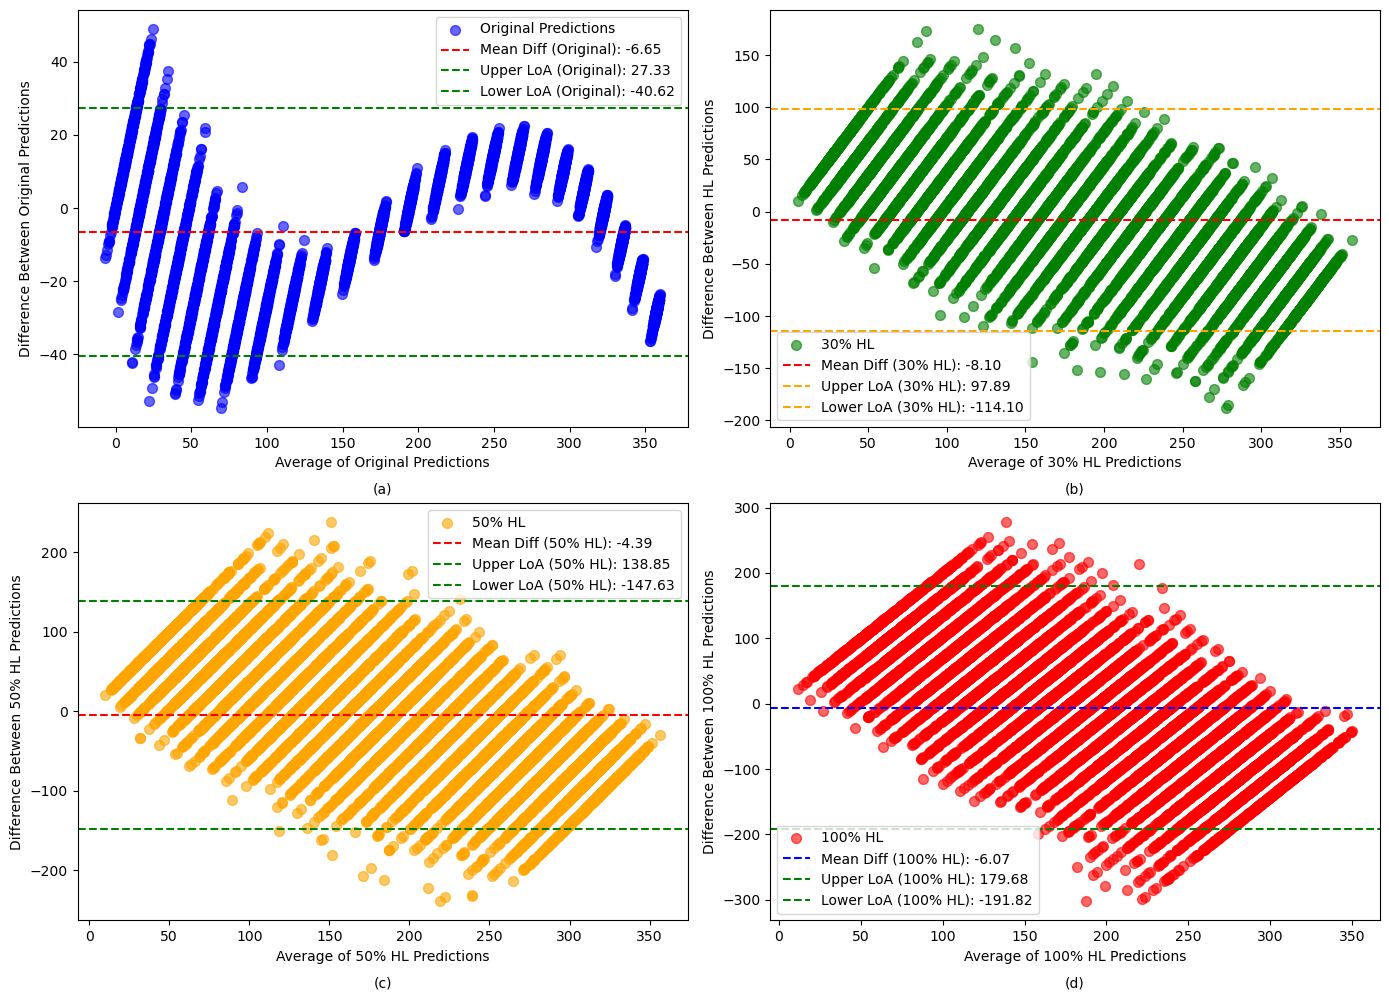

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Get predictions from the original and noisy models
y_pred_original = model.predict(X_val_reshaped)  # Predictions for original data
y_pred_noisy_30 = model.predict(X_val_noisy_30_reshaped)  # Predictions for 30% noisy data
y_pred_noisy_50 = model.predict(X_val_noisy_50_reshaped)  # Predictions for 50% noisy data
y_pred_noisy_100 = model.predict(X_val_noisy_100_reshaped)  # Predictions for 100% noisy data

# Calculate the differences between the predictions and the true values (y_val_energy)
differences_original = y_pred_original.flatten() - y_val_energy.to_numpy().flatten()  # Differences for original data
differences_noisy_30 = y_pred_noisy_30.flatten() - y_val_energy.to_numpy().flatten()  # Differences for 30% noisy data
differences_noisy_50 = y_pred_noisy_50.flatten() - y_val_energy.to_numpy().flatten()  # Differences for 50% noisy data
differences_noisy_100 = y_pred_noisy_100.flatten() - y_val_energy.to_numpy().flatten()  # Differences for 100% noisy data

# Calculate the averages of the predictions and true values
averages_original = (y_pred_original.flatten() + y_val_energy.to_numpy().flatten()) / 2
averages_noisy_30 = (y_pred_noisy_30.flatten() + y_val_energy.to_numpy().flatten()) / 2
averages_noisy_50 = (y_pred_noisy_50.flatten() + y_val_energy.to_numpy().flatten()) / 2
averages_noisy_100 = (y_pred_noisy_100.flatten() + y_val_energy.to_numpy().flatten()) / 2

# Calculate the mean and standard deviation of the differences for both models
mean_diff_original = np.mean(differences_original)
std_diff_original = np.std(differences_original)

mean_diff_noisy_30 = np.mean(differences_noisy_30)
std_diff_noisy_30 = np.std(differences_noisy_30)

mean_diff_noisy_50 = np.mean(differences_noisy_50)
std_diff_noisy_50 = np.std(differences_noisy_50)

mean_diff_noisy_100 = np.mean(differences_noisy_100)
std_diff_noisy_100 = np.std(differences_noisy_100)

# Calculate the upper and lower limits of agreement (LoA) for both models
upper_LoA_original = mean_diff_original + 1.96 * std_diff_original
lower_LoA_original = mean_diff_original - 1.96 * std_diff_original

upper_LoA_noisy_30 = mean_diff_noisy_30 + 1.96 * std_diff_noisy_30
lower_LoA_noisy_30 = mean_diff_noisy_30 - 1.96 * std_diff_noisy_30

upper_LoA_noisy_50 = mean_diff_noisy_50 + 1.96 * std_diff_noisy_50
lower_LoA_noisy_50 = mean_diff_noisy_50 - 1.96 * std_diff_noisy_50

upper_LoA_noisy_100 = mean_diff_noisy_100 + 1.96 * std_diff_noisy_100
lower_LoA_noisy_100 = mean_diff_noisy_100 - 1.96 * std_diff_noisy_100

# Create the side-by-side Bland-Altman plot (4 plots)
plt.figure(figsize=(14, 10))

# First Plot: Bland-Altman for Original Data Model
plt.subplot(2, 2, 1)  # First subplot (2 rows, 2 columns, first plot)
plt.scatter(averages_original, differences_original, color='blue', alpha=0.6, label='Original Predictions', s=50)
plt.axhline(mean_diff_original, color='red', linestyle='--', label=f'Mean Diff (Original): {mean_diff_original:.2f}')
plt.axhline(upper_LoA_original, color='green', linestyle='--', label=f'Upper LoA (Original): {upper_LoA_original:.2f}')
plt.axhline(lower_LoA_original, color='green', linestyle='--', label=f'Lower LoA (Original): {lower_LoA_original:.2f}')
plt.xlabel('Average of Original Predictions')
plt.ylabel('Difference Between Original Predictions')
#plt.title('Bland-Altman Plot: Original Model')
plt.legend()
plt.text(0.5, -0.15, '(a)', ha='center', va='center', transform=plt.gca().transAxes)

# Second Plot: Bland-Altman for 30% Noisy Data Model
plt.subplot(2, 2, 2)  # Second subplot (2 rows, 2 columns, second plot)
plt.scatter(averages_noisy_30, differences_noisy_30, color='green', alpha=0.6, label='30% HL', s=50)
plt.axhline(mean_diff_noisy_30, color='red', linestyle='--', label=f'Mean Diff (30% HL): {mean_diff_noisy_30:.2f}')
plt.axhline(upper_LoA_noisy_30, color='orange', linestyle='--', label=f'Upper LoA (30% HL): {upper_LoA_noisy_30:.2f}')
plt.axhline(lower_LoA_noisy_30, color='orange', linestyle='--', label=f'Lower LoA (30% HL): {lower_LoA_noisy_30:.2f}')
plt.xlabel('Average of 30% HL Predictions')
plt.ylabel('Difference Between HL Predictions')
#plt.title('Bland-Altman Plot: 30% HL')
plt.legend()
plt.text(0.5, -0.15, '(b)', ha='center', va='center', transform=plt.gca().transAxes)

# Third Plot: Bland-Altman for 50% Noisy Data Model
plt.subplot(2, 2, 3)  # Third subplot (2 rows, 2 columns, third plot)
plt.scatter(averages_noisy_50, differences_noisy_50, color='orange', alpha=0.6, label='50% HL', s=50)
plt.axhline(mean_diff_noisy_50, color='red', linestyle='--', label=f'Mean Diff (50% HL): {mean_diff_noisy_50:.2f}')
plt.axhline(upper_LoA_noisy_50, color='green', linestyle='--', label=f'Upper LoA (50% HL): {upper_LoA_noisy_50:.2f}')
plt.axhline(lower_LoA_noisy_50, color='green', linestyle='--', label=f'Lower LoA (50% HL): {lower_LoA_noisy_50:.2f}')
plt.xlabel('Average of 50% HL Predictions')
plt.ylabel('Difference Between 50% HL Predictions')
#plt.title('Bland-Altman Plot: 50% HL')
plt.legend()
plt.text(0.5, -0.15, '(c)', ha='center', va='center', transform=plt.gca().transAxes)

# Fourth Plot: Bland-Altman for 100% Noisy Data Model
plt.subplot(2, 2, 4)  # Fourth subplot (2 rows, 2 columns, fourth plot)
plt.scatter(averages_noisy_100, differences_noisy_100, color='red', alpha=0.6, label='100% HL', s=50)
plt.axhline(mean_diff_noisy_100, color='blue', linestyle='--', label=f'Mean Diff (100% HL): {mean_diff_noisy_100:.2f}')
plt.axhline(upper_LoA_noisy_100, color='green', linestyle='--', label=f'Upper LoA (100% HL): {upper_LoA_noisy_100:.2f}')
plt.axhline(lower_LoA_noisy_100, color='green', linestyle='--', label=f'Lower LoA (100% HL): {lower_LoA_noisy_100:.2f}')
plt.xlabel('Average of 100% HL Predictions')
plt.ylabel('Difference Between 100% HL Predictions')
#plt.title('Bland-Altman Plot: 100% HL')
plt.legend()
plt.text(0.5, -0.15, '(d)', ha='center', va='center', transform=plt.gca().transAxes)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


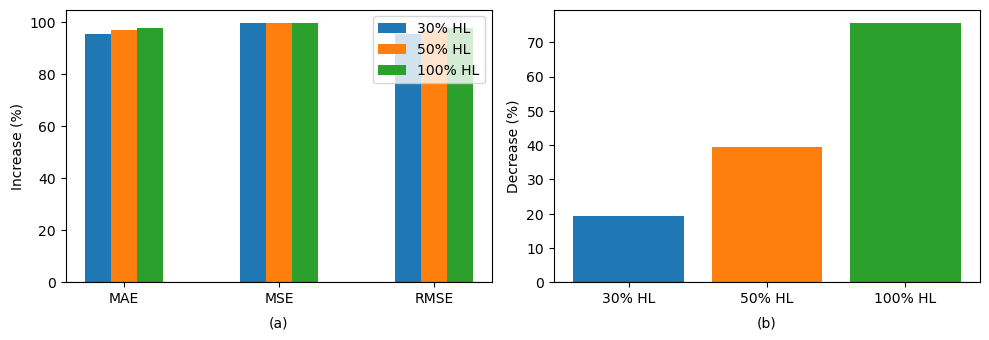

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# HL levels and colors
hl_levels = ['30% HL', '50% HL', '100% HL']
metrics_error = ['MAE', 'MSE', 'RMSE']
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Performance loss values (positive % values)
performance_loss_error = {
    '30% HL': [95.61, 99.80, 95.47],
    '50% HL': [97.04, 99.90, 96.90],
    '100% HL': [97.89, 99.95, 97.71]
}

performance_loss_r2 = {
    '30% HL': 19.19,
    '50% HL': 39.39,
    '100% HL': 75.76
}

# Bar positioning with space between grouped metrics
n_metrics = len(metrics_error)
x = np.arange(n_metrics) * 1.5  # add spacing between groups
bar_width = 0.25

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.5))

# --- Left Plot: MAE, MSE, RMSE ---
for i, hl in enumerate(hl_levels):
    values = performance_loss_error[hl]
    offset = (i - 1) * bar_width  # center the bars around the tick
    ax1.bar(x + offset, values, width=bar_width, label=hl, color=colors[i])

#ax1.set_title('Performance Loss in Error Metrics')
ax1.set_ylabel('Increase (%)')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_error)
ax1.axhline(0, color='black', linewidth=0.8)
ax1.legend()

# Add (a) label below x-axis in the left plot
ax1.text(0.5, -0.15, '(a)', ha='center', va='center', transform=ax1.transAxes)

# --- Right Plot: R² Loss ---
r2_losses = [performance_loss_r2[hl] for hl in hl_levels]
ax2.bar(hl_levels, r2_losses, color=colors)
#ax2.set_title('R² Score Decrease')
ax2.set_ylabel('Decrease (%)')
ax2.axhline(0, color='black', linewidth=0.8)

# Add (b) label below x-axis in the right plot
ax2.text(0.5, -0.15, '(b)', ha='center', va='center', transform=ax2.transAxes)

# Final layout
plt.tight_layout()
plt.show()
